<a href="https://colab.research.google.com/github/Kalgrand/SPAM/blob/main/spam_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

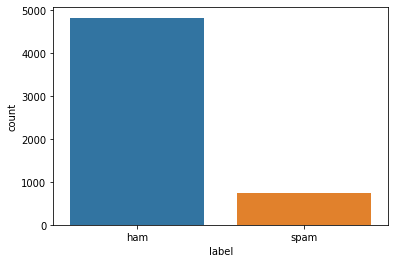

In [20]:
#klasyfikator spamu - nauka

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pickle
import tensorflow as tf
import wordcloud

plik = pd.read_csv("spam.csv",encoding='latin-1')
plik.head()

data = plik.copy()
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

#zmiana nazwy kolumn
data = data.rename(columns={"v1":"label", "v2":"text"})
data.head()
data.label.value_counts()

#wizualizacja danych
sns.countplot(data['label'])
plt.show

data['label'] = data['label'].map({'spam':1, 'ham':0})


In [72]:
# wstępne przetwarzanie tekstu
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# budowanie modelu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

# dzielenie danych na train and test set
from sklearn.model_selection import train_test_split

x = data['text'].values
y = data['label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.30, 
                                                        random_state=42)

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(x_train)

# kodowanie
encoded_train = t.texts_to_sequences(x_train)
encoded_test = t.texts_to_sequences(x_test)
print(encoded_train[0:2], "\n")

# maksymalna długość słów 
max_length = 8
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
print(padded_train, "\n")

vocab_size = len(t.word_index) + 1

# zdefiniowanie modelu
model = Sequential()
model.add(Embedding(vocab_size, 24, input_length=max_length))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# kompilacja modelu
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# podsumowanie modelu
print(model.summary())

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# dopasowanie modelu
model.fit(x=padded_train,
         y=y_train,
         epochs=10,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

[[2, 1519, 7, 203, 5, 921, 188, 93, 3460, 599, 3461, 38, 730, 188, 48, 19, 131, 3462, 182, 3463, 679, 49, 3464, 88, 38, 5, 329, 54], [33, 58, 1520, 256, 209, 48, 785]] 

[[ 679   49 3464 ...    5  329   54]
 [  33   58 1520 ...   48  785    0]
 [   3   29  105 ...   13  146  231]
 ...
 [2000   30 7412 ...  254   30 7413]
 [ 739 2270 1432 ...    0    0    0]
 [   8  146   20 ...    8  276  175]] 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 8, 24)             177936    
_________________________________________________________________
flatten_9 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 500)               96500     
_________________________________________________________________
dense_37 (Dense)             (None, 200)          

1 = SPAM , 0 = HAM 

Wynik : 0 



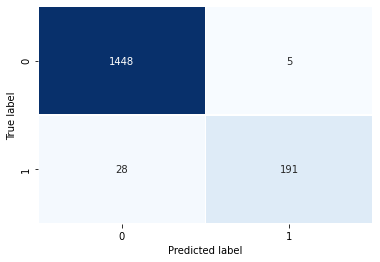

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer

#predykcja
preds = (model.predict(padded_test) > 0.5).astype("int32")

#tablica pomyłek
plot_confusion_matrix(y_test, preds)

sms = ["We know someone who you know that fancies you. Call 09058097218 to find out who. POBox 6, LS15HB "]
sms1 = ["Even my brother is not like to speak with me. They treat me like aids patent."]
sms_proc = tokenizer.texts_to_sequences(sms1)
sms_proc = pad_sequences(sms_proc, maxlen=max_length, padding='post')
pred = (model.predict(sms_proc) > 0.5).astype("int32").item()
print("1 = SPAM , 0 = HAM \n")
print("Wynik :", pred, "\n")